## All Imports

In [1]:
# Cell for all imports

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt
from urllib.parse import urlparse

## Reading and Exploring the Data

In [2]:
# Read data into dataframes

shared_articles_df = pd.read_csv('shared_articles.csv')
user_interactions_df = pd.read_csv('users_interactions.csv')

In [3]:
# Print shared_articles_df head

shared_articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [4]:
# Print user_interactions_df head

user_interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [5]:
# Number of rows in both dataframes

print("Number of rows in shared_articles_df: ", len(shared_articles_df))
print("Number of rows in user_interactions_df: ", len(user_interactions_df))

Number of rows in shared_articles_df:  3122
Number of rows in user_interactions_df:  72312


In [6]:
# See number of rows with non-NA values in both dataframes in each column

print("Shared Articles Dataframe: \n")
print(shared_articles_df.count(), "\n\n")
print("User Interactions Dataframe: \n")
print(user_interactions_df.count())

Shared Articles Dataframe: 

timestamp          3122
eventType          3122
contentId          3122
authorPersonId     3122
authorSessionId    3122
authorUserAgent     680
authorRegion        680
authorCountry       680
contentType        3122
url                3122
title              3122
text               3122
lang               3122
dtype: int64 


User Interactions Dataframe: 

timestamp      72312
eventType      72312
contentId      72312
personId       72312
sessionId      72312
userAgent      56918
userRegion     56907
userCountry    56918
dtype: int64


In general, I do not think that the device/browser used to either share the article on the platform in the first place, or interact with it, will have any impact on it going viral. Moreover, these are columns with a large number of NA values. Therefore, I feel that I can drop these from my dataframes.

In [7]:
# Dropping userAgent and authorUserAgent columns

shared_articles_df.drop(columns='authorUserAgent', inplace=True)
user_interactions_df.drop(columns='userAgent', inplace=True)

In [8]:
# Split the shared_articles dataframe into two dataframes - one with content that has been shared 
# and other with content that has been removed.

# Contains all rows with eventType = "CONTENT SHARED"
content_shared_df = shared_articles_df[shared_articles_df['eventType'].str.contains("SHARED")]
print("Number of rows in content_shared_df: ", len(content_shared_df))

# Contains all rows with eventType = "CONTENT REMOVED"
content_removed_df = shared_articles_df[shared_articles_df['eventType'].str.contains("REMOVED")]
print("Number of rows in content_removed_df: ", len(content_removed_df))

Number of rows in content_shared_df:  3047
Number of rows in content_removed_df:  75


Since 2.4% of the rows have eventType "CONTENT REMOVED" and it does not make sense to check the virality of articles that are not on the platform, we will only consider the articles that are in the content_shared_df dataframe.

Generating a new feature to see if time spent on platform has any effect on virality.

To find this, I subtracted the timestamp at which content was shared from when the content was removed. If the article does not have event type "CONTENT REMOVED", I used 31st December 2017 11:59:59 PM GMT as the default timestamp (in reality, current timestamp would be used for an updated dataset) as the dataset was last updated three years ago on Kaggle.

In [9]:
join_df = content_shared_df.merge(content_removed_df, how='left', 
                                  on=['contentId', 'authorPersonId', 'contentType', 'url', 'text', 'lang'])

In [10]:
# Replacing any NaN Author Regions/Countries in content_shared_df with values from content_removed_df

join_df.authorRegion_x.fillna(join_df.authorRegion_y, inplace=True)
join_df.authorCountry_x.fillna(join_df.authorCountry_y, inplace=True)
join_df.count()

timestamp_x          3048
eventType_x          3048
contentId            3048
authorPersonId       3048
authorSessionId_x    3048
authorRegion_x        670
authorCountry_x       670
contentType          3048
url                  3048
title_x              3048
text                 3048
lang                 3048
timestamp_y            65
eventType_y            65
authorSessionId_y      65
authorRegion_y         11
authorCountry_y        11
title_y                65
dtype: int64

In [11]:
# Replacing all NaN values in timestamp_y column (timestamp at which article was removed) with 1514764799
# which is the epoch timestamp for 31st December 2017 11:59:59 PM GMT

join_df.timestamp_y.fillna(1514764799, inplace=True)

In [12]:
# Creating timeOnPlatform column

join_df['timeOnPlatform'] = join_df['timestamp_y'] - join_df['timestamp_x']

In [13]:
# Dropping irrelevant columns

# authorSessionId_x, eventType_x and eventType_y - not needed as this won't affect virality
# timestamp_x and timestamp_y - not needed as timeOnPlatform column has been created
# authorSessionId_y, authorRegion_y, authorCountry_y, title_y - not needed as these are basically duplicate columns

join_df.drop(columns=['authorSessionId_x', 'eventType_x', 'eventType_y', 'timestamp_x', 'timestamp_y', 'authorSessionId_y', 
                     'authorRegion_y', 'authorCountry_y', 'title_y'], inplace=True)

In [14]:
# Renaming columns ending with _x

join_df.rename(columns={"authorRegion_x": "authorRegion", "authorCountry_x": "authorCountry", "title_x": "title"}, inplace=True)

In [15]:
# Replacing NaN values in authorRegion and authorCountry with most common value of the column

print(join_df['authorRegion'].value_counts()[:1])
print(join_df['authorCountry'].value_counts()[:1])

join_df.authorRegion.fillna("SP", inplace=True)
join_df.authorCountry.fillna("BR", inplace=True)

SP    525
Name: authorRegion, dtype: int64
BR    603
Name: authorCountry, dtype: int64


In [16]:
join_df.head()

,contentId,authorPersonId,authorRegion,authorCountry,contentType,url,title,text,lang,timeOnPlatform
0,-4110354420726924665,4340306774493623681,SP,BR,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,55570811.0
1,-7292285110016212249,4340306774493623681,SP,BR,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,55570653.0
2,-6151852268067518688,3891637997717104548,SP,BR,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,55570325.0
3,2448026894306402386,4340306774493623681,SP,BR,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,55570302.0
4,-2826566343807132236,4340306774493623681,SP,BR,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,55570277.0


It is possible that articles from a particular domain are more likely to go viral than some others. For this, I am going to extract the domain from the URL column and store it in another column called "urlDomain".

In [17]:
# Creating function to return domain name

def get_domain(row):
    domain_name = urlparse(row['url']).netloc
    return(domain_name)

In [18]:
# Creating urlDomain column

join_df['urlDomain'] = join_df.apply(lambda row: get_domain(row), axis=1)

join_df.head()

,contentId,authorPersonId,authorRegion,authorCountry,contentType,url,title,text,lang,timeOnPlatform,urlDomain
0,-4110354420726924665,4340306774493623681,SP,BR,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,55570811.0,www.nytimes.com
1,-7292285110016212249,4340306774493623681,SP,BR,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,55570653.0,cointelegraph.com
2,-6151852268067518688,3891637997717104548,SP,BR,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,55570325.0,cloudplatform.googleblog.com
3,2448026894306402386,4340306774493623681,SP,BR,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,55570302.0,bitcoinmagazine.com
4,-2826566343807132236,4340306774493623681,SP,BR,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,55570277.0,www.coindesk.com


In [19]:
join_df['urlDomain'].nunique()

1045

For running regression models, it is better to replace categorical values with one-hot encoding. This has been done for:
- lang
- contentType
- authorRegion
- authorCountry
- urlDomain

In [20]:
#  performing one hot encoding

join_df = pd.get_dummies(join_df, columns=['lang', 'contentType', 'authorRegion', 'authorCountry', 'urlDomain'], 
                         prefix=['lang', 'content', 'authorRegion', 'authorCountry', 'urlDomain'])

In [21]:
join_df.columns

Index(['contentId', 'authorPersonId', 'url', 'title', 'text', 'timeOnPlatform',
       'lang_en', 'lang_es', 'lang_ja', 'lang_la',
       ...
       'urlDomain_www.zivtech.com', 'urlDomain_www.ztop.com.br',
       'urlDomain_www1.folha.uol.com.br', 'urlDomain_www1.valor.com.br',
       'urlDomain_www2.deloitte.com', 'urlDomain_www2.portalnovidade.com.br',
       'urlDomain_xamarinbr.azurewebsites.net',
       'urlDomain_xorcatt.wordpress.com', 'urlDomain_zeroturnaround.com',
       'urlDomain_zoocha.com'],
      dtype='object', length=1083)

Now, I will process the User Interactions Dataframe and get the number of bookmarks, comments, likes, follows and views each article has. I will also create a column called interactions which will have the total number of interactions that each article has i.e. sum of all user interactions for the article.

In [22]:
# Getting number of bookmarks, comments, likes, follows and views per article

interactions_per_article = user_interactions_df.groupby(['contentId','eventType'])['timestamp'].count().reset_index()
interactions_per_article = interactions_per_article.pivot_table(index='contentId', columns='eventType', values='timestamp')

In [23]:
# Fill all NaN values with 0

interactions_per_article.fillna(0, inplace=True)
interactions_per_article.head()

eventType,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW
contentId,,,,,
-9222795471790223670,1.0,2.0,3.0,4.0,16.0
-9216926795620865886,1.0,1.0,1.0,3.0,15.0
-9194572880052200111,2.0,1.0,1.0,4.0,21.0
-9192549002213406534,0.0,1.0,0.0,5.0,50.0
-9190737901804729417,0.0,0.0,0.0,1.0,8.0


In [24]:
# Creating Interactions column

interactions_per_article['Interactions'] = interactions_per_article['BOOKMARK'] + interactions_per_article['COMMENT CREATED'] + interactions_per_article['FOLLOW'] + interactions_per_article['LIKE'] + interactions_per_article['VIEW']
interactions_per_article.head()

eventType,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,Interactions
contentId,,,,,,
-9222795471790223670,1.0,2.0,3.0,4.0,16.0,26.0
-9216926795620865886,1.0,1.0,1.0,3.0,15.0,21.0
-9194572880052200111,2.0,1.0,1.0,4.0,21.0,29.0
-9192549002213406534,0.0,1.0,0.0,5.0,50.0,56.0
-9190737901804729417,0.0,0.0,0.0,1.0,8.0,9.0


To train the model, we need the ground truth label values. For this, I will use the formula given:

VIRALITY = 1 * VIEW + 4 * LIKE + 10 * COMMENT + 25 * FOLLOW + 100 * BOOKMARK

In [25]:
# Creating ground truth labels

interactions_per_article['VIRALITY'] = 100*interactions_per_article['BOOKMARK'] + 10*interactions_per_article['COMMENT CREATED'] + 25*interactions_per_article['FOLLOW'] + 4*interactions_per_article['LIKE'] + interactions_per_article['VIEW']
interactions_per_article.head()

eventType,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,Interactions,VIRALITY
contentId,,,,,,,
-9222795471790223670,1.0,2.0,3.0,4.0,16.0,26.0,227.0
-9216926795620865886,1.0,1.0,1.0,3.0,15.0,21.0,162.0
-9194572880052200111,2.0,1.0,1.0,4.0,21.0,29.0,272.0
-9192549002213406534,0.0,1.0,0.0,5.0,50.0,56.0,80.0
-9190737901804729417,0.0,0.0,0.0,1.0,8.0,9.0,12.0


In [26]:
# Creating contentID column from Index

interactions_per_article = interactions_per_article.reset_index()
interactions_per_article.head()

eventType,contentId,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,Interactions,VIRALITY
0,-9222795471790223670,1.0,2.0,3.0,4.0,16.0,26.0,227.0
1,-9216926795620865886,1.0,1.0,1.0,3.0,15.0,21.0,162.0
2,-9194572880052200111,2.0,1.0,1.0,4.0,21.0,29.0,272.0
3,-9192549002213406534,0.0,1.0,0.0,5.0,50.0,56.0,80.0
4,-9190737901804729417,0.0,0.0,0.0,1.0,8.0,9.0,12.0


In [27]:
# Joining both processed dataframes

processed_df = join_df.merge(interactions_per_article, how='inner', on='contentId')

In [28]:
print(len(processed_df))
processed_df.columns

2980


Index(['contentId', 'authorPersonId', 'url', 'title', 'text', 'timeOnPlatform',
       'lang_en', 'lang_es', 'lang_ja', 'lang_la',
       ...
       'urlDomain_xorcatt.wordpress.com', 'urlDomain_zeroturnaround.com',
       'urlDomain_zoocha.com', 'BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE',
       'VIEW', 'Interactions', 'VIRALITY'],
      dtype='object', length=1090)

In [29]:
# Dropping columns that will not be used for modeling

model_df = processed_df.drop(columns=['contentId', 'authorPersonId', 'url', 'title', 'text'], inplace=False)

In [30]:
model_df.columns

Index(['timeOnPlatform', 'lang_en', 'lang_es', 'lang_ja', 'lang_la', 'lang_pt',
       'content_HTML', 'content_RICH', 'content_VIDEO', 'authorRegion_13',
       ...
       'urlDomain_xorcatt.wordpress.com', 'urlDomain_zeroturnaround.com',
       'urlDomain_zoocha.com', 'BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE',
       'VIEW', 'Interactions', 'VIRALITY'],
      dtype='object', length=1085)

## Models

### Splitting into Train and Test sets

In [31]:
train, test = train_test_split(model_df, test_size=0.2)

### Principal Component Analysis for Dimensionality Reduction

In [32]:
# Normalizing non categorical data

numerical_col = ['timeOnPlatform', 'BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE', 'VIEW', 'Interactions']
scaler = StandardScaler()
scaler.fit(train[numerical_col])
train[numerical_col] = scaler.transform(train[numerical_col])
test[numerical_col] = scaler.transform(test[numerical_col])
train.head()

c:\users\sanjk\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\sanjk\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\users\sanjk\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,timeOnPlatform,lang_en,lang_es,lang_ja,lang_la,lang_pt,content_HTML,content_RICH,content_VIDEO,authorRegion_13,...,urlDomain_xorcatt.wordpress.com,urlDomain_zeroturnaround.com,urlDomain_zoocha.com,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,Interactions,VIRALITY
2046,-0.210625,1,0,0,0,0,1,0,0,0,...,0,0,0,1.301384,0.387996,0.515491,0.642745,0.846188,0.880492,394.0
1735,0.068761,1,0,0,0,0,1,0,0,0,...,0,0,0,-0.471811,-0.424104,-0.441620,-0.580651,-0.647979,-0.661871,3.0
789,0.707891,0,0,0,0,1,1,0,0,0,...,0,0,0,-0.471811,1.200096,-0.441620,1.254443,0.173813,0.282433,69.0
2724,-1.175482,1,0,0,0,0,1,0,0,0,...,0,0,0,0.119254,2.012197,2.429711,2.171990,1.369147,1.541504,298.0
1685,0.133289,1,0,0,0,0,1,0,0,0,...,0,0,0,-0.471811,0.387996,0.515491,-0.274802,-0.685333,-0.598917,41.0


In [33]:
# Separating out the features

train_x = train.drop(columns=['VIRALITY'], inplace=False)
train_x = train_x.loc[:,:].values
test_x = test.drop(columns=['VIRALITY'], inplace=False)
test_x = test_x.loc[:,:].values

# Separating out the target

train_y = train.loc[:,['VIRALITY']].values
test_y = test.loc[:,['VIRALITY']].values

Text(0, 0.5, 'cumulative explained variance')

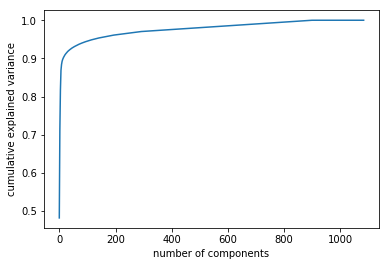

In [34]:
# Choosing number of components

pca = PCA().fit(train_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

It seems that around 120 components explain over 95% of the variance.

In [35]:
pca = PCA(0.95).fit(train_x)
pca.n_components_

123

In [36]:
# Applying PCA mapping to train and test sets

train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

### K Fold Cross Validation

In [37]:
kf = KFold(n_splits = 10) # Define the split - into 2 folds 
kf.get_n_splits(train_x)

10

### Lasso Regression

In [38]:
# Training Lasso model

reg = LassoCV(cv=10, random_state=0).fit(train_x, train_y)

c:\users\sanjk\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [39]:
pred_y = reg.predict(test_x)

In [40]:
# Find test accuracy

print(mean_squared_error(test_y, pred_y))
print(r2_score(test_y, pred_y))

11.467318753297876
0.9999265929963578
